In [32]:
import matplotlib.pyplot as plt
import torch
import pytorch_measure as pm
import numpy as np
N = 17 # number of atoms
M = 2000 # Number of datapoints
amin = -5
amax = 3
verbose = True
dev = 'cpu'


torch.manual_seed(1)

def regression_model(a, x):
    return a+x

x = torch.linspace(0, 10, M).view(-1, 1)
data = regression_model(torch.randn(M).to(dev) - 2, x.view(1, -1)).view(-1, 1)
w = torch.rand(N,dtype=torch.float).to(dev)
w = torch.nn.parameter.Parameter(w/w.sum())
l = torch.linspace(amin, amax, N, requires_grad=False).to(dev)

index = []
for i in range(M):
    ab = (regression_model(l, x[i]) - data[i]).abs()
    index.append(torch.argmin(ab))

def NLLLoss(m:list[pm.Measure]):
    return -(m[0].weights[index]).log().sum()

sd = (l[index] - data)**2
def WardLoss(w):
    return sum(sd * w[index])

def K(d):
        return 1/np.sqrt(2*np.pi)*np.exp(-d**2/2)
h=1.06*M**(-1/5)
# K( (y - yj) / h )
kde_mat = K((data.view(-1,1) - regression_model(l, x)) / h)

#a = torch.sum(kde_mat, dim=0)

def KDENLLLoss(m):
    return -(torch.matmul(kde_mat, m[0].weights.view(-1,1)) / (M*h)).log().sum()


Epoch: 0          Loss: 5278.405273438 LR: [0.1]
Epoch: 2          Lr was reduced to: [0.06999999999999999]
Epoch: 3          Lr was reduced to: [0.048999999999999995]
Epoch: 4          Lr was reduced to: [0.0343]
Epoch: 6          Lr was reduced to: [0.024009999999999997]
Epoch: 7          Lr was reduced to: [0.016806999999999996]
Epoch: 8          Lr was reduced to: [0.011764899999999997]
Epoch: 9          Lr was reduced to: [0.008235429999999997]
Epoch: 10         Lr was reduced to: [0.005764800999999997]
Epoch: 11         Lr was reduced to: [0.004035360699999998]
Epoch: 20         Loss: 4592.243164062 LR: [0.004035360699999998]
Epoch: 30         Loss: 4496.145996094 LR: [0.004035360699999998]
Epoch: 40         Loss: 4420.158203125 LR: [0.004035360699999998]
Epoch: 50         Loss: 4359.619140625 LR: [0.004035360699999998]
Epoch: 59         Lr was reduced to: [0.0028247524899999983]
Epoch: 60         Lr was reduced to: [0.0019773267429999985]
Epoch: 61         Lr was reduced to: [0.

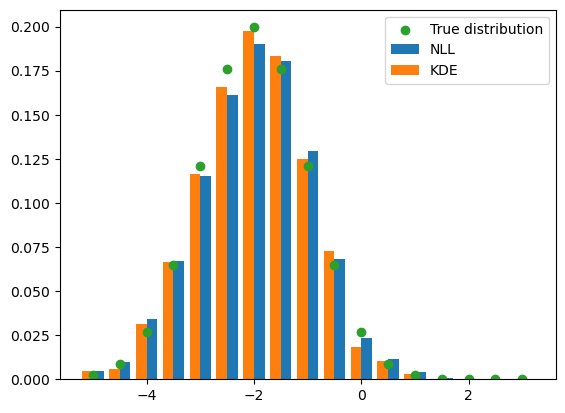

In [33]:
measure = pm.Measure(locations=l, weights=w, device=dev)

opt_NLL = pm.Optimizer([measure], lr=1e-1)
new_mes = opt_NLL.minimize(NLLLoss, verbose=True, print_freq=10, max_epochs=1000, tol_const=1e-3, adaptive=True)

opt_KDE = pm.Optimizer([measure], lr=1e-1)
new_mesKDE = opt_KDE.minimize(KDENLLLoss, verbose=True, print_freq=10, max_epochs=1000, tol_const=1e-3, adaptive=True)

mu=0 #Create true values
sigma=1
xs = l.detach()
y=1/(np.sqrt(2*np.pi)*sigma)*torch.exp(-(xs+2-mu)**2/(2*sigma**2))
y/=sum(y) #Normalize


plt.bar(l + 0.1, new_mes[0].weights.tolist(), width = 0.2, label='NLL')
plt.bar(l - 0.1, new_mesKDE[0].weights.tolist(), width = 0.2, label='KDE')
plt.scatter(xs, y, zorder=2, label="True distribution")
plt.legend()

plt.show()
